### Библиотеки

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report


### Обработка данных negative and positive

In [2]:
with open('ids_first_company_negative.txt', 'r') as file:
    raw_data = file.read() 

# Подготовка заголовка
header = 'Ids of negative AB people'

#  Обработка данных
data_string = ''.join((c if c.isdigit() else ' ') for c in raw_data)

#Разделение строки на список
data_list = data_string.split()

# Преобразование строк в целые числа
data_nums = [int(i) for i in data_list]

# Создание DataFrame
df_negative = pd.DataFrame(data_nums)
df_negative.columns = [header]


In [3]:
with open('ids_first_company_positive.txt', 'r') as file:
    raw_data = file.read() 

header = 'Ids of positive AB people'

data_string = ''.join((c if c.isdigit() else ' ') for c in raw_data)
data_list = data_string.split()
data_nums = [int(i) for i in data_list]

df_positive = pd.DataFrame(data_nums)
df_positive.columns = [header]


In [4]:
df_negative.drop_duplicates(inplace=True)
df_negative.duplicated().sum()

0

In [5]:
df_positive.drop_duplicates(inplace=True)
df_positive.duplicated().sum()

0

In [6]:
df_negative.isnull().sum()


Ids of negative AB people    0
dtype: int64

In [7]:
df_positive.isnull().sum()


Ids of positive AB people    0
dtype: int64

### Обработка персональных данных

In [8]:
df_merged = pd.read_csv('updated_merged_personal_data.csv')
df_personal = pd.read_csv('personal_data.csv')


In [9]:
# Объединяем два датафрейма
df_new = pd.concat([df_merged, df_personal], ignore_index=True)


In [10]:
df_new.drop_duplicates(inplace=True)
df_new.duplicated().sum()

0

In [11]:
df_new.isnull().sum()

id               0
gender       15748
age              0
education        0
city             0
country          0
dtype: int64

In [12]:
# Подключаемся к базе данных
conn = sqlite3.connect('/Users/arkadiypishkin/Desktop/ИТОГОВАЯ/shop_database.db')

# Получаем список таблиц в базе данных
tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
print("Таблицы в базе данных:", tables)

Таблицы в базе данных: [('purchases',), ('personal_data_coeffs',), ('personal_data',)]


In [13]:
# Чтение данных
df_purchases = pd.read_sql_query("SELECT * FROM purchases", conn)
df_coeffs = pd.read_sql_query("SELECT * FROM personal_data_coeffs", conn)
df_personal = pd.read_sql_query("SELECT * FROM personal_data", conn)


In [14]:
# Сначала объединяем df_coeffs и df_personal
df_temp = pd.merge(df_coeffs, df_personal, on='id', how='inner')

# Затем объединяем результат с df_purchases
df_all = pd.merge(df_temp, df_purchases, on='id', how='inner')


In [15]:
# Убираем '/'
df_all = df_all.apply(lambda x: x.str.replace('/', '', regex=False) if x.dtype == "object" else x)


In [16]:
# Объединяем датафреймы
df = pd.concat([df_new, df_all], ignore_index=True)


In [17]:
# Фильтруем строки, где country равно 32
df_country = df[df['country'] == 32]


In [18]:
df_country.duplicated().sum()

0

In [19]:
df_country.isnull().sum()

id                    0
gender            15651
age                   0
education             0
city                  0
country               0
lbt_coef         131525
ac_coef          131525
sm_coef          131525
personal_coef    131525
product          131525
colour           233114
cost             131525
product_sex      398037
base_sale        131525
dt               131525
dtype: int64

In [20]:
col = 'personal_coef', 'lbt_coef', 'ac_coef', 'sm_coef', 'base_sale', 'cost', 'product_sex'
idx = df_country.index
df_country.loc[idx, col] = df_country.loc[idx, col].fillna(df_country.loc[idx, col].mean())


In [21]:
cols = 'product', 'colour', 'dt'
idxs = df_country.index
df_country.loc[idxs, cols] = df_country.loc[idxs, cols].fillna(df_country.loc[idxs, cols].mode())


In [22]:
df_country.isnull().sum()

id                    0
gender            15651
age                   0
education             0
city                  0
country               0
lbt_coef              0
ac_coef               0
sm_coef               0
personal_coef         0
product          131524
colour           233113
cost                  0
product_sex           0
base_sale             0
dt               131524
dtype: int64

In [23]:
df_country.colour.unique()

array(['черный', nan, 'белыйсиний', ..., 'песочныйрозовый',
       'фиолетовыйбелыймятный', 'черныйциан'], dtype=object)

In [24]:
# Подсчитываем количество уникальных значений в колонке 'color'
colour_counts = df_country['colour'].value_counts()

# Фильтруем только те значения, которые повторяются более одного раза
repeated_colour = colour_counts[colour_counts > 1]

if not repeated_colour.empty:
    print("Повторяющиеся значения в колонке 'colour':")
    print(repeated_colour)
else:
    print("Повторяющихся значений в колонке 'colour' нет.")

Повторяющиеся значения в колонке 'colour':
colour
черный                     110953
белый                       36035
чёрный                      31100
синий                       29829
темно-синий                 22996
                            ...  
темно-зеленыйкоричневый         2
бежевыйсерыйбелый               2
серыйчерныйголубой              2
многоцветный                    2
кораллбелый                     2
Name: count, Length: 1422, dtype: int64


In [25]:
# Находим самое часто встречающееся значение в колонках 'colour' и 'product'
most_frequent_colours = df_country['colour'].mode()[0]
most_frequent_products = df_country['product'].mode()[0]
most_frequent_dt = df_country['dt'].mode()[0]

# Заменяем пропущенные значения на самое часто встречающееся значение в каждой колонке
df_country['colour'].fillna(most_frequent_colours, inplace=True)
df_country['product'].fillna(most_frequent_products, inplace=True)
df_country['dt'].fillna(most_frequent_dt, inplace=True)

# Проверяем количество пропущенных значений
print(df_country.isnull().sum())

/var/folders/v7/htyd58cd6rb3h4p9l73slr8w0000gn/T/ipykernel_2187/2844656276.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_country['colour'].fillna(most_frequent_colours, inplace=True)
/var/folders/v7/htyd58cd6rb3h4p9l73slr8w0000gn/T/ipykernel_2187/2844656276.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['colour'].filln

id                   0
gender           15651
age                  0
education            0
city                 0
country              0
lbt_coef             0
ac_coef              0
sm_coef              0
personal_coef        0
product              0
colour               0
cost                 0
product_sex          0
base_sale            0
dt                   0
dtype: int64


In [26]:

df_country_32 = df_country.copy()
df_country_32 = df_country_32[['gender', 'id', 'age', 'personal_coef', 'dt', 'cost', 'city']]


In [27]:
# Удаление строк с пропущенным полом
df_country_32 = df_country_32.dropna(subset=['gender'], how='any')

# Данные для классификации
X = df_country_32.drop(columns=['gender', 'id'])  # Убираем ненужные столбцы
y = df_country_32['gender']  # Целевая переменная

# Заполнение пропусков (если есть)
for col in X.columns:
    mode_value = X[col].value_counts().index[0]  # Находим моду для каждого столбца
    X[col] = X[col].fillna(mode_value)            # Заполняем пропуски найденной модой
    


In [28]:
# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
# Масштабирование данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [30]:
# Выбор модели
clf = RandomForestClassifier(random_state=42)

# Обучение
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [31]:
# Прогнозирование
y_pred = clf.predict(X_test)

# Вычисление F-меры
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F-мера: {f1:.2f}")

# Подробный отчёт
print(classification_report(y_test, y_pred))


F-мера: 0.92
              precision    recall  f1-score   support

        -2.0       0.05      0.00      0.01      2591
         0.0       0.94      0.91      0.93     68235
         1.0       0.91      0.96      0.94     85282

    accuracy                           0.92    156108
   macro avg       0.63      0.63      0.62    156108
weighted avg       0.91      0.92      0.92    156108



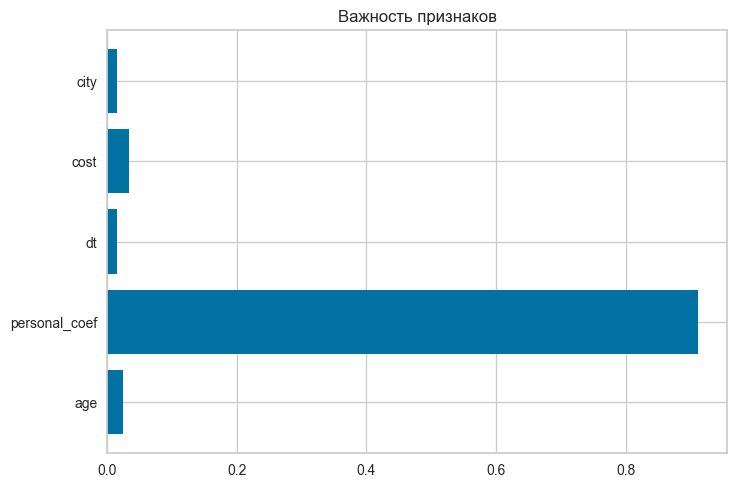

In [89]:
# Важность признаков в модели RandomForest.

importances = clf.feature_importances_
feature_names = X.columns
plt.barh(feature_names, importances)
plt.title("Важность признаков")
plt.show()

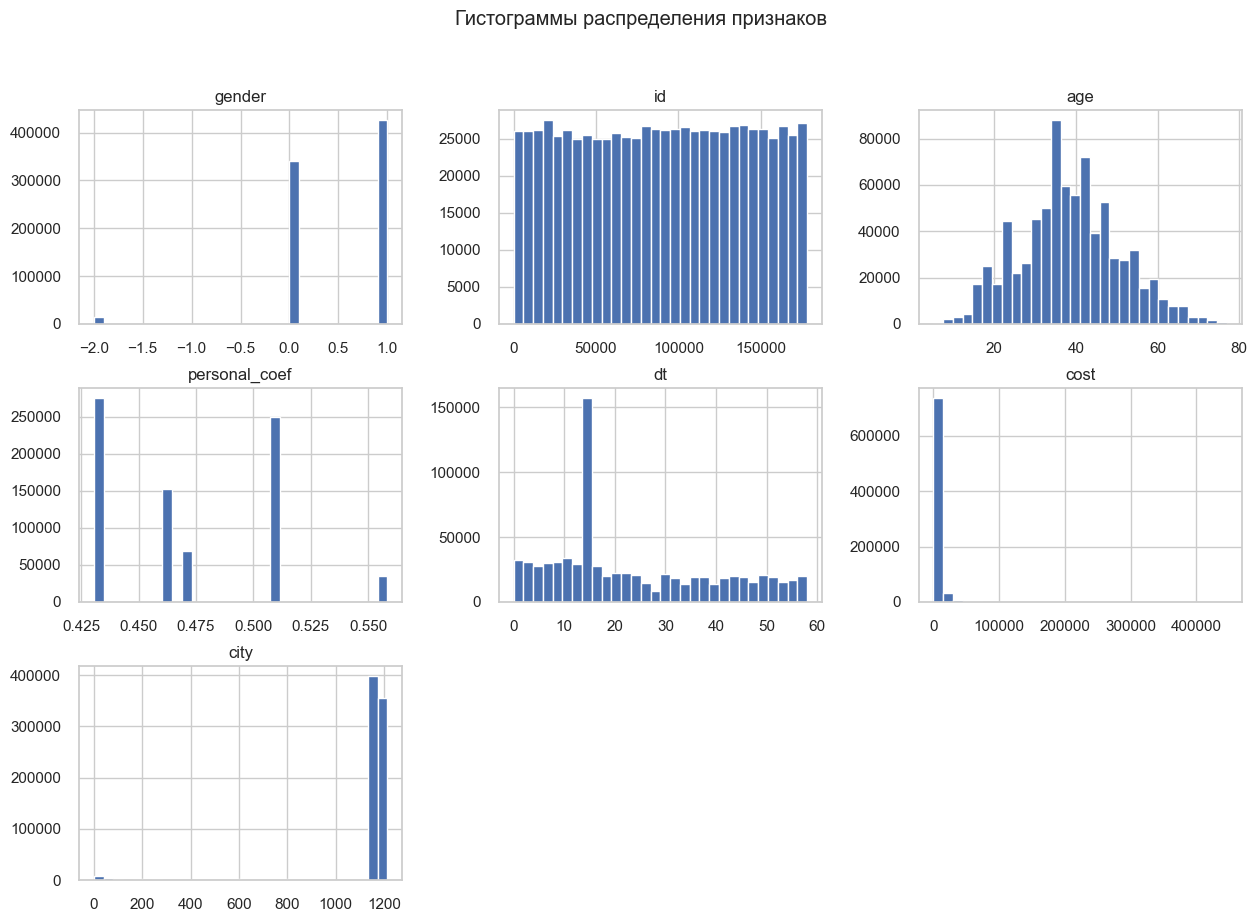

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка стиля графиков
sns.set(style="whitegrid")

# Построение гистограмм для каждого признака
df_country_32.hist(bins=30, figsize=(15, 10))
plt.suptitle("Гистограммы распределения признаков")
plt.show()

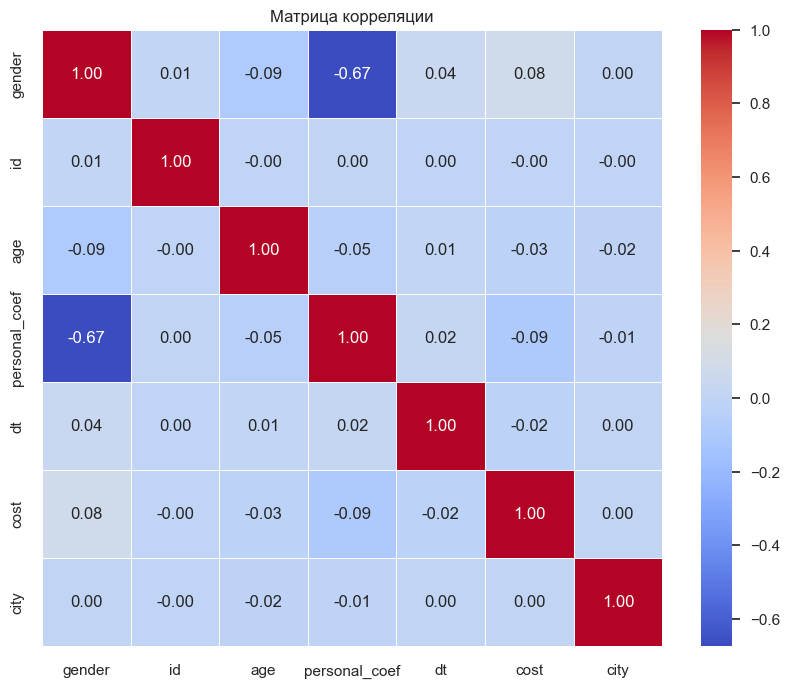

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

# Вычисление матрицы корреляции
corr_matrix = df_country_32.corr()

# Построение тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Матрица корреляции")
plt.show()

In [92]:
# Заменяем пропущенные значения на средние значения
df_country_32['personal_coef'] = df_country_32['personal_coef'].fillna(df_country_32['personal_coef'].mean())


In [93]:
def grubbs_test(df_country_32, column):
    zscore = stats.zscore(df_country_32[column])
    abs_zscore = np.abs(zscore)
    outliers = df_country_32.index[abs_zscore >= 3]
    return outliers

outliers = grubbs_test(df_country_32, 'personal_coef')
print(outliers)

Index([], dtype='int64')


In [94]:
def calculate_outliers_3sigma(data):
    low = data.mean() - 3 * data.std()
    high = data.mean() + 3 * data.std()
    boundaries = (low, high)
    return boundaries

boundaries = calculate_outliers_3sigma(df_country_32.personal_coef)
boundaries

(0.3595822282165189, 0.5804327032763088)

In [95]:
low = 0.29416145933077337
high = 0.6282447838142697

# Вычисляем среднее значение
mean_value = df_country_32['personal_coef'].mean()

# Заменяем выбросы на среднее значение
df_country_32['personal_coef'] = df_country_32['personal_coef'].apply(
    lambda x: mean_value if x < low or x > high else x
)

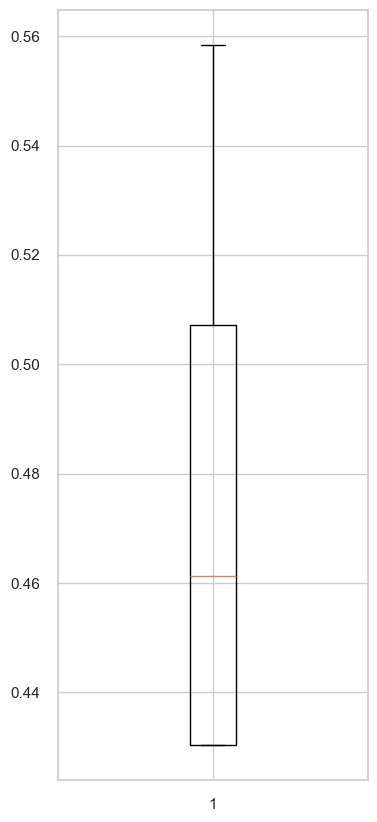

In [96]:
plt.figure(figsize=(4, 10))
plt.boxplot(df_country_32.personal_coef, sym='+')
plt.show()

### Объединение персональных данных с данными negative and positive

In [37]:
# Объединение DataFrame по ID клиентов

merged_negative = pd.merge(df_country_32, df_negative, left_on='id', right_on='Ids of negative AB people')
# Удаляем столбец 'Ids of negative AB people'
result_negative = merged_negative.drop(columns=['Ids of negative AB people'])

merged_positive = pd.merge(df_country_32, df_positive, left_on='id', right_on='Ids of positive AB people')
# Удаляем столбец 'Ids of positive AB people'
result_positive = merged_positive.drop(columns=['Ids of positive AB people'])


### Исследование маркетинговых кампаний

#### Сравнение positive и negative

In [38]:
result_negative_new = result_negative [(result_negative ['dt'] >= 5) & (result_negative ['dt'] <= 16)] 
result_positive_new = result_positive [(result_positive ['dt'] >= 5) & (result_positive ['dt'] <= 16)]


In [39]:
result_negative_new.isnull().sum()

gender           0
id               0
age              0
personal_coef    0
dt               0
cost             0
city             0
dtype: int64

In [40]:
#  Проведение A/B-теста

# t-тест для независимых выборок
t_stat, p_value = stats.ttest_ind(result_positive['cost'], result_negative['cost'])
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Вывод результатов теста
alpha = 0.05  # уровень значимости

if p_value < alpha:
    print(f"Нулевая гипотеза отвергается (p-value = {p_value}). Различия между кампаниями статистически значимы.")
else:
    print(f"Нулевая гипотеза не отвергается (p-value = {p_value}). Различия между кампаниями не статистически значимы.")


T-statistic: -3.059136877089862, P-value: 0.0022202762359199227
Нулевая гипотеза отвергается (p-value = 0.0022202762359199227). Различия между кампаниями статистически значимы.


In [41]:
# Средний чек
avg_order_positive = result_positive_new['cost'].mean()
avg_order_negative = result_negative_new['cost'].mean()

# Общий доход
total_revenue_positive = result_positive_new['cost'].sum()
total_revenue_negative = result_negative_new['cost'].sum()

# Конверсия
conversion_rate_positive = result_positive_new['id'].nunique() / len(result_positive_new)  
conversion_rate_negative = result_negative_new['id'].nunique() / len(result_negative_new)

# Вывод результатов
print("Кампания с персональной скидкой:")
print(f"Средний чек: {avg_order_positive}")
print(f"Общий доход: {total_revenue_positive}")
print(f"Конверсия: {conversion_rate_positive}")

print()

print("nКампания без персональной скидки:")
print(f"Средний чек: {avg_order_negative}")
print(f"Общий доход: {total_revenue_negative}")
print(f"Конверсия: {conversion_rate_negative}")


Кампания с персональной скидкой:
Средний чек: 5358.26937472568
Общий доход: 145251966.21006373
Конверсия: 0.1841153902906891

nКампания без персональной скидки:
Средний чек: 5570.410668303657
Общий доход: 124715924.45265058
Конверсия: 0.22153736209745858


In [42]:
# Определение более удачной кампании

if total_revenue_positive > total_revenue_negative:
    print("Кампания с персональной скидкой была более успешной.")
else:
    print("Кампания без персональной скидки была более успешной.")

Кампания с персональной скидкой была более успешной.


##### графики

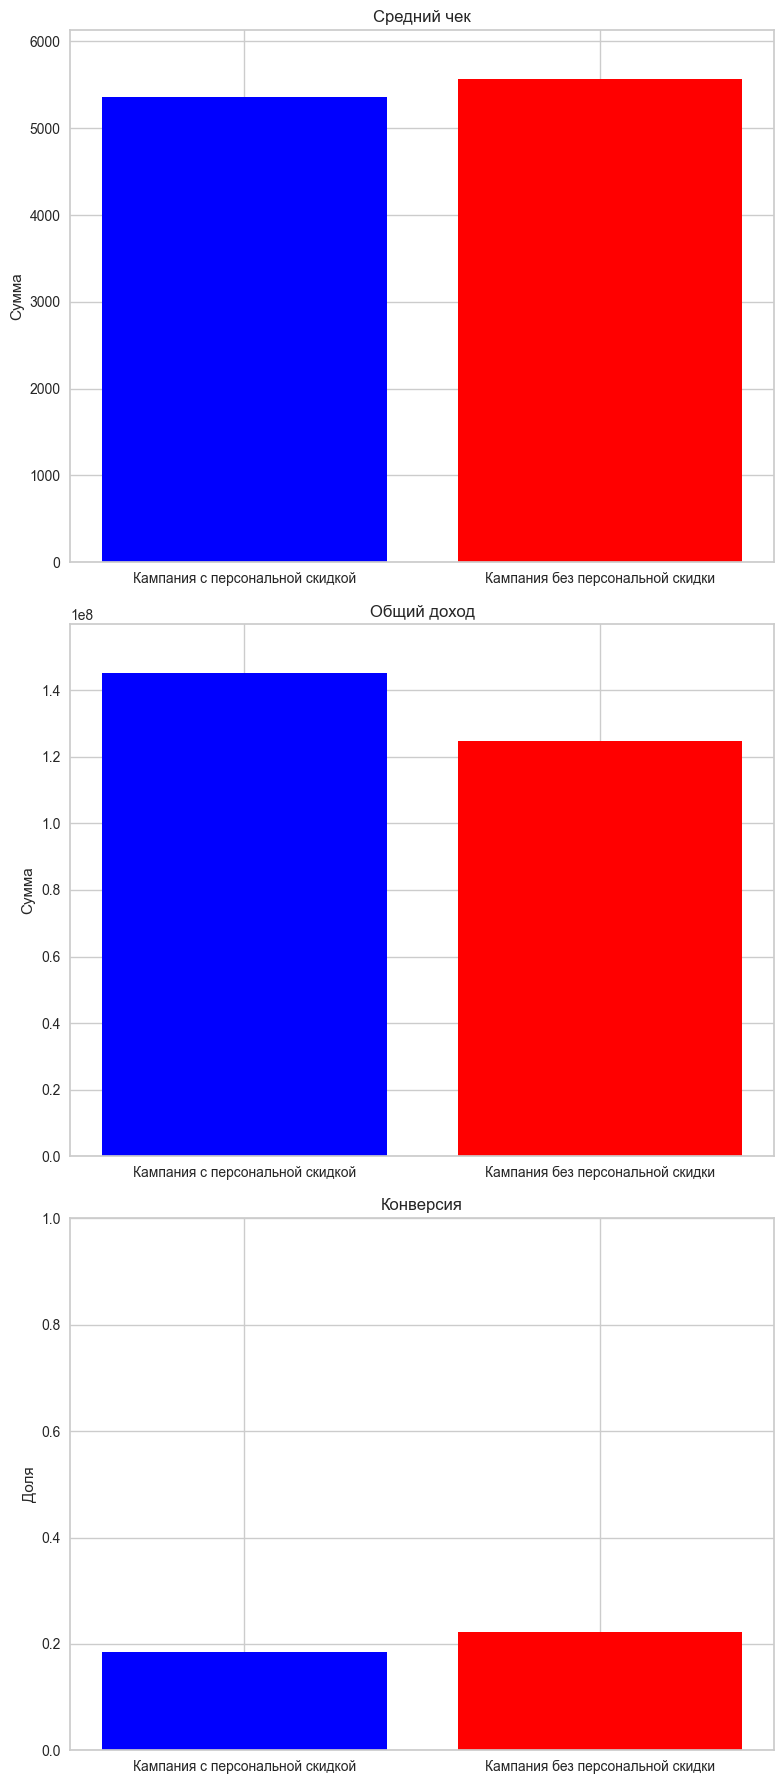

In [43]:
import matplotlib.pyplot as plt

# Данные для визуализации
categories = ['Кампания с персональной скидкой', 'Кампания без персональной скидки']
avg_orders = [avg_order_positive, avg_order_negative]
total_revenues = [total_revenue_positive, total_revenue_negative]
conversion_rates = [conversion_rate_positive, conversion_rate_negative]

# Создание графиков
fig, axs = plt.subplots(3, 1, figsize=(8, 18))

# График 1: Средний чек
axs[0].bar(categories, avg_orders, color=['blue', 'red'])
axs[0].set_title('Средний чек')
axs[0].set_ylabel('Сумма')
axs[0].set_ylim(0, max(avg_orders) * 1.1)

# График 2: Общий доход
axs[1].bar(categories, total_revenues, color=['blue', 'red'])
axs[1].set_title('Общий доход')
axs[1].set_ylabel('Сумма')
axs[1].set_ylim(0, max(total_revenues) * 1.1)

# График 3: Конверсия
axs[2].bar(categories, conversion_rates, color=['blue', 'red'])
axs[2].set_title('Конверсия')
axs[2].set_ylabel('Доля')
axs[2].set_ylim(0, 1)  # Поскольку конверсия в процентах от 0 до 1

# Отображение графиков
plt.tight_layout()
plt.show()

##### Выводы и рекомендации

#### Компания с банером

In [44]:
df2_negative = result_negative_new[(result_negative_new['city'] == 1134) & (result_negative_new['dt'].isin([15, 45]))] 
df2_positive = result_positive_new[(result_positive_new['city'] == 1134) & (result_positive_new['dt'].isin([15, 45]))]


In [45]:
# Пример для проверки значимости разницы по стоимости (cost)
t_stat, p_value = stats.ttest_ind(df2_negative['cost'], df2_positive['cost'], equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Вывод результатов теста
alpha = 0.05  # уровень значимости

if p_value < alpha:
    print(f"Нулевая гипотеза отвергается (p-value = {p_value}). Различия между кампаниями статистически значимы.")
else:
    print(f"Нулевая гипотеза не отвергается (p-value = {p_value}). Различия между кампаниями не статистически значимы.")
 

T-statistic: -0.6944836148048399, P-value: 0.4875152114951661
Нулевая гипотеза не отвергается (p-value = 0.4875152114951661). Различия между кампаниями не статистически значимы.


In [46]:
# Средний чек
avg_order_positive_2 = df2_positive['cost'].mean()
avg_order_negative_2 = df2_negative['cost'].mean()

# Общий доход
total_revenue_positive_2 = df2_positive['cost'].sum()
total_revenue_negative_2 = df2_negative['cost'].sum()

# Конверсия
conversion_rate_positive_2 = df2_positive['id'].nunique() / len(df2_positive)  
conversion_rate_negative_2 = df2_negative['id'].nunique() / len(df2_negative)

# Вывод результатов
print("Кампания с банером:")
print(f"Средний чек: {avg_order_positive_2}")
print(f"Общий доход: {total_revenue_positive_2}")
print(f"Конверсия: {conversion_rate_positive_2}")

print()

print("nКампания без банера:")
print(f"Средний чек: {avg_order_negative_2}")
print(f"Общий доход: {total_revenue_negative_2}")
print(f"Конверсия: {conversion_rate_negative_2}")


Кампания с банером:
Средний чек: 5560.87684729064
Общий доход: 3386574.0
Конверсия: 0.4433497536945813

nКампания без банера:
Средний чек: 5240.7
Общий доход: 3092013.0
Конверсия: 0.411864406779661


In [47]:
# Определение более удачной кампании

if total_revenue_positive_2 > total_revenue_negative_2:
    print("Кампания с банером была более успешной.")
else:
    print("Кампания без банера была более успешной.")
 

Кампания с банером была более успешной.


##### графики 

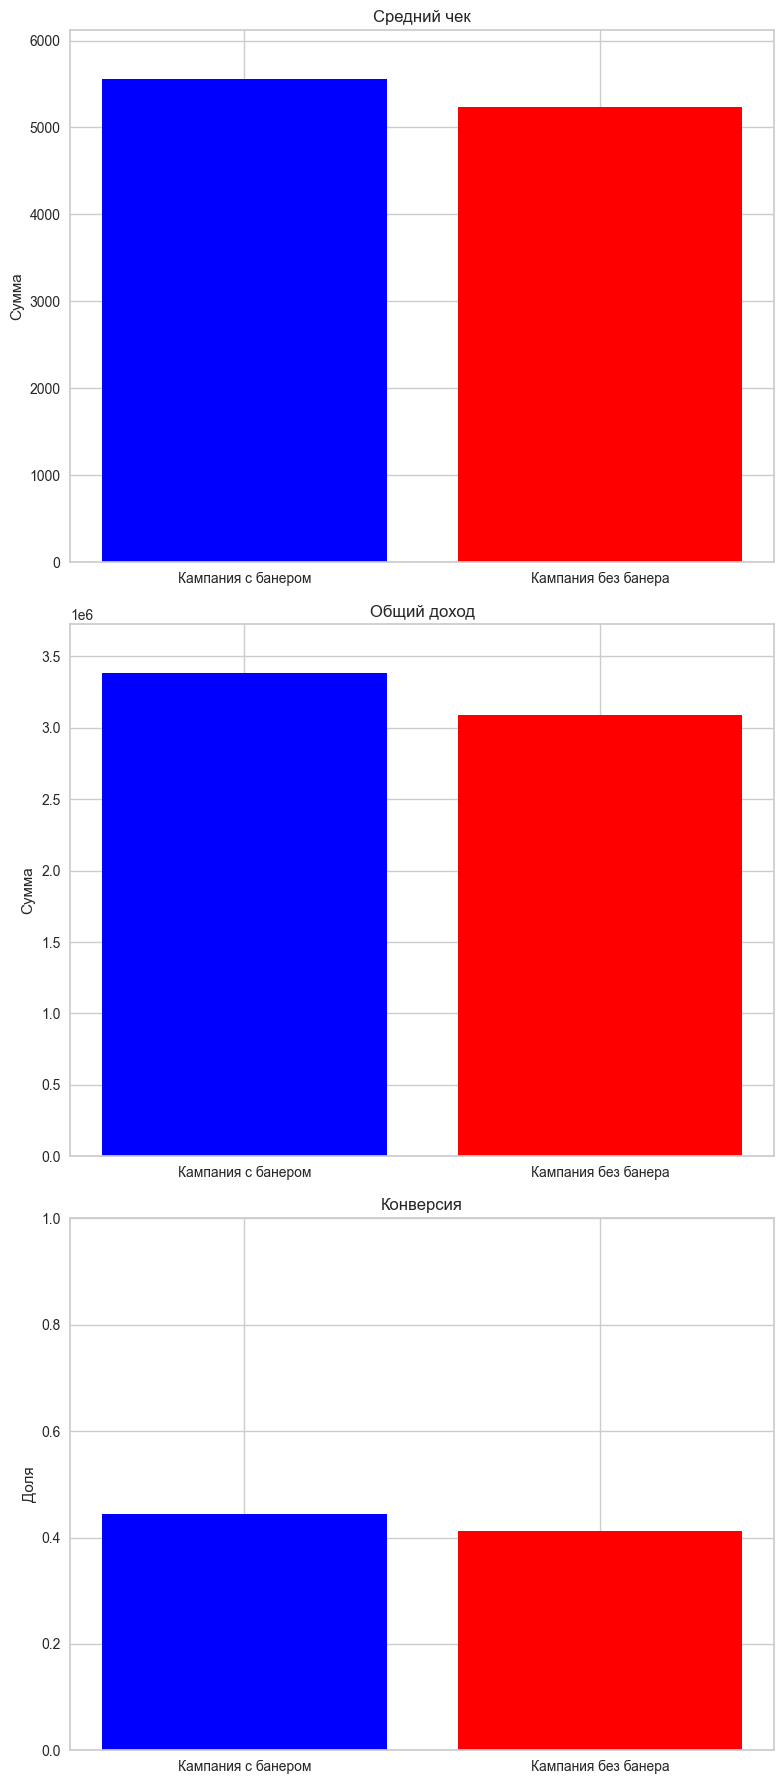

In [48]:
# Данные для визуализации
categories_2 = ['Кампания с банером', 'Кампания без банера']
avg_orders_2 = [avg_order_positive_2, avg_order_negative_2]
total_revenues_2 = [total_revenue_positive_2, total_revenue_negative_2]
conversion_rates_2 = [conversion_rate_positive_2, conversion_rate_negative_2]

# Создание графиков
fig, axs = plt.subplots(3, 1, figsize=(8, 18))

# График 1: Средний чек
axs[0].bar(categories_2, avg_orders_2, color=['blue', 'red'])
axs[0].set_title('Средний чек')
axs[0].set_ylabel('Сумма')
axs[0].set_ylim(0, max(avg_orders_2) * 1.1)

# График 2: Общий доход
axs[1].bar(categories_2, total_revenues_2, color=['blue', 'red'])
axs[1].set_title('Общий доход')
axs[1].set_ylabel('Сумма')
axs[1].set_ylim(0, max(total_revenues_2) * 1.1)

# График 3: Конверсия
axs[2].bar(categories_2, conversion_rates_2, color=['blue', 'red'])
axs[2].set_title('Конверсия')
axs[2].set_ylabel('Доля')
axs[2].set_ylim(0, 1)  # Поскольку конверсия в процентах от 0 до 1

# Отображение графиков
plt.tight_layout()
plt.show()

##### Выводы и рекомендации

#### Кластеризация

In [49]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Кластеризация аудитории: используем алгоритм K-means для кластеризации клиентов.
# Преобразование категориальной колонки education в числовые значения

df_klast = df_country.sample(n=100000, random_state=42)

le = LabelEncoder()
df_klast['education'] = le.fit_transform(df_klast['education'])


In [50]:
# Удаление строк с бесконечными значениями
# features = df_klast.copy()
# features.replace([np.inf, -np.inf], np.nan, inplace=True)
# features.dropna(inplace=True)

In [51]:
# Объединение DataFrame
klast_merge = df_klast.merge(
    df_country_32[['id', 'gender']],  # выбираем только нужные колонки из df_country_32
    on='id',                            # объединяем по колонке id
    how='left',                         # сохраняем все строки из df_country
    suffixes=('', '_new')              # добавляем суффикс для новых колонок
)

# Заполнение пропусков в gender значениями из df_country_32
klast_merge['gender'] = klast_merge['gender'].combine_first(klast_merge['gender_new'])

# Удаление временной колонки
klast_merge.drop(columns=['gender_new'], inplace=True)

In [52]:
klast_merge.drop_duplicates(inplace=True)
klast_merge.duplicated().sum()

0

In [53]:
# Подготовка данных для кластеризации
features = klast_merge[['cost', 'personal_coef', 'gender', 'age', 'education']]


In [54]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


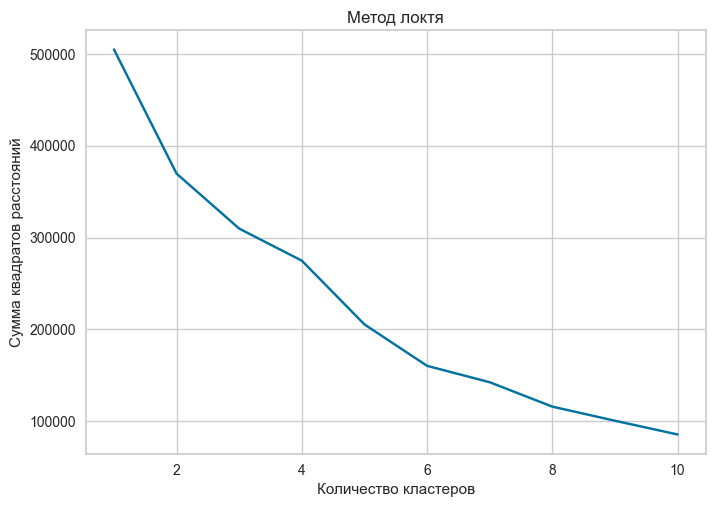

In [55]:
# Метод локтя для выбора количества кластеров

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia)
plt.xlabel('Количество кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Метод локтя')
plt.show()


In [56]:
# Кластеризация
kmeans = KMeans(n_clusters=6, random_state=42)
klast_merge['cluster'] = kmeans.fit_predict(scaled_features)


In [57]:
cluster_analysis = klast_merge.groupby('cluster').agg({
    'cost': ['mean', 'sum'],
    'product': lambda x: x.value_counts().index[0],  # наиболее популярный товар
    'id': 'count'  # количество записей в каждом кластере
}).reset_index()
cluster_analysis

cluster          cost                                             product  \
                   mean           sum                              <lambda>   
0       0  67832.796917  7.481958e+07  Велосипед горный Stern Force 2.0 29"   
1       1   5148.460488  2.034517e+08                   Брюки мужские Demix   
2       2   5000.360000  2.262663e+07                   Сабо Crocs Crocband   
3       3   4913.524763  7.607119e+07                   Брюки мужские Demix   
4       4   4115.444996  1.076107e+08                   Брюки мужские Demix   
5       5   3999.962659  5.694747e+07                   Брюки мужские Demix   

      id  
   count  
0   1103  
1  39517  
2   4525  
3  15482  
4  26148  
5  14237

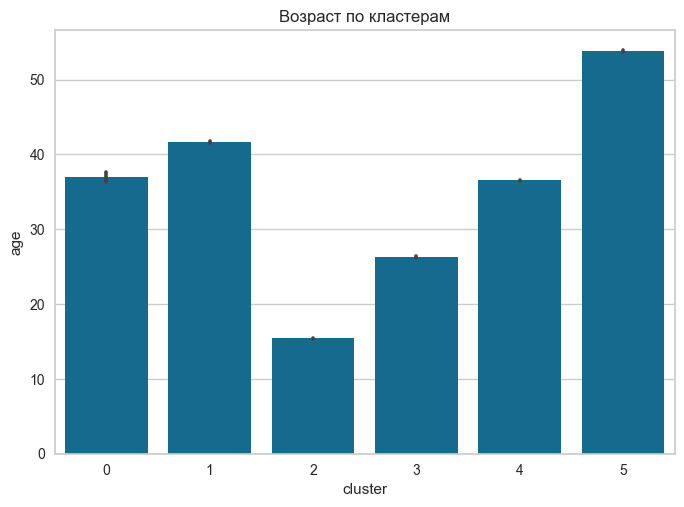

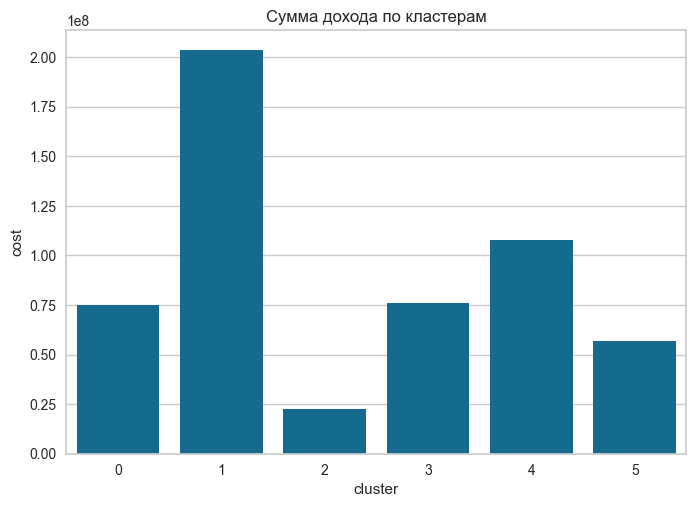

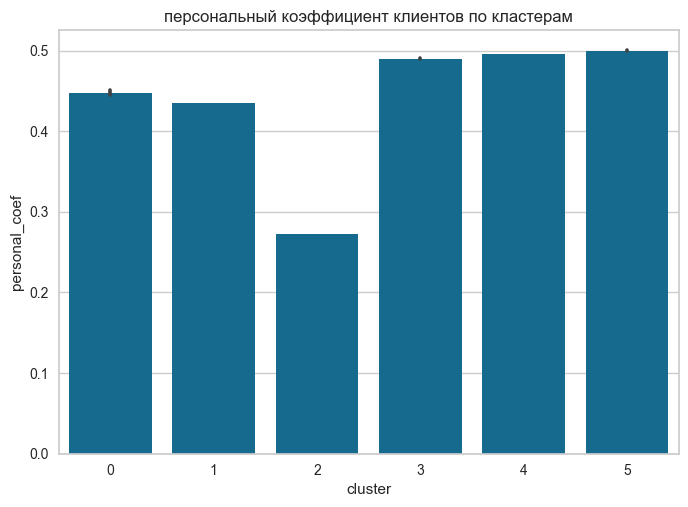

In [58]:
import seaborn as sns

# Визуализация характеристик кластеров
sns.barplot(x='cluster', y='age', data=klast_merge)
plt.title('Возраст по кластерам')
plt.show()

# Группируем данные по 'cluster' и вычисляем сумму 'cost'
df_aggregated = klast_merge.groupby('cluster', as_index=False)['cost'].sum()

sns.barplot(x='cluster', y='cost', data=df_aggregated)
plt.title('Сумма дохода по кластерам')
plt.show()

sns.barplot(x='cluster', y='personal_coef', data=klast_merge)
plt.title('персональный коэффициент клиентов по кластерам')
plt.show()

#### Город 1188

In [59]:
# Объединение DataFrame
df_1188 = df_country.merge(
    df_country_32[['id', 'gender']],  # выбираем только нужные колонки из df_country_32
    on='id',                            # объединяем по колонке id
    how='left',                         # сохраняем все строки из df_country
    suffixes=('', '_new')              # добавляем суффикс для новых колонок
)

# Заполнение пропусков в gender значениями из df_country_32
df_1188['gender'] = df_1188['gender'].combine_first(df_1188['gender_new'])

# Удаление временной колонки
df_1188.drop(columns=['gender_new'], inplace=True)


# df_1188 = pd.merge(df_country, df_country_32, on='id', how='left') 


In [60]:
# df_country
city_1188 = df_1188[(df_1188['city'] == 1188)]

In [61]:
# Получаем уникальные идентификаторы клиентов
unique_ids_1188 = city_1188['id'].unique()

num_test_clients_1188=len(unique_ids_1188)

# Случайным образом выбераем клиентов для тестовой группы
np.random.seed(42)
if num_test_clients_1188 > 100:
    test_group_ids_1188 = np.random.choice(unique_ids_1188, size=100, replace=False)
else:
    test_group_ids_1188 = unique_ids_1188 # Если клиентов меньше или равно 100, берем всех

In [62]:
# Случайное распределение клиентов по группам
city_1188['group'] = np.where(city_1188['id'].isin(test_group_ids_1188), 'test', 'control')

/var/folders/v7/htyd58cd6rb3h4p9l73slr8w0000gn/T/ipykernel_2187/3185305040.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_1188['group'] = np.where(city_1188['id'].isin(test_group_ids_1188), 'test', 'control')


In [63]:
# Расчет основных метрик

# Конверсия
conversion_rate_1188 = city_1188.groupby('group')['id'].nunique() / city_1188.groupby('group')['id'].count()
print('Конверсия', conversion_rate_1188)

# Средний чек
average_order_value_1188 = city_1188.groupby('group')['cost'].sum() / city_1188.groupby('group')['id'].nunique()
print('Средний чек', average_order_value_1188)


Конверсия group
control    0.007404
test       0.008757
Name: id, dtype: float64
Средний чек group
control    657209.299596
test       680032.860692
dtype: float64


In [64]:
# T-тест для среднего чека
control_aov_1188 = city_1188[city_1188['group'] == 'control']['cost']
test_aov_1188 = city_1188[city_1188['group'] == 'test']['cost']

t_stat, p_value = stats.ttest_ind(control_aov_1188, test_aov_1188)

# Проверка гипотезы
alpha = 0.05
if p_value < alpha:
    print("Результаты статистически значимы")
else:
    print("Результаты статистически не значимы")
print('p_value:', p_value)
print('t_stat:', t_stat)

Результаты статистически значимы
p_value: 1.7234999763278296e-45
t_stat: -14.156069428905584


#### кластеризация

In [65]:
# Кластеризация аудитории: используем алгоритм K-means для кластеризации клиентов.
# Преобразование категориальной колонки education в числовые значения

city_1188_clast = city_1188.copy()

le = LabelEncoder()
city_1188_clast['education'] = le.fit_transform(city_1188_clast['education'])


In [66]:
# Подготовка данных для кластеризации
features_1188 = city_1188_clast[['cost', 'personal_coef', 'gender', 'age', 'education']]


In [67]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_1188)


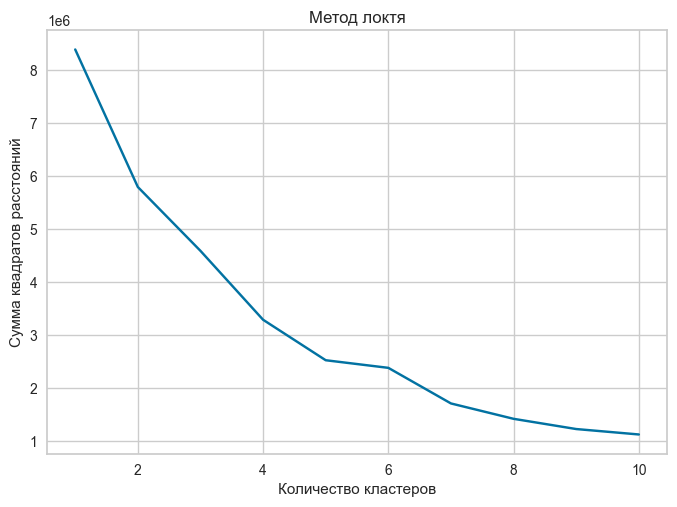

In [68]:
# Метод локтя для выбора количества кластеров

inertia2 = []
k_range2 = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia2.append(kmeans.inertia_)

plt.plot(k_range2, inertia2)
plt.xlabel('Количество кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Метод локтя')
plt.show()

In [69]:
# Кластеризация
kmeans = KMeans(n_clusters=5, random_state=42)
city_1188_clast['cluster'] = kmeans.fit_predict(scaled_features)


In [70]:
cluster_analysis2 = city_1188_clast.groupby('cluster').agg({
    'cost': ['mean', 'sum'],
    'product': lambda x: x.value_counts().index[0],  # наиболее популярный товар
    'id': 'count'  # количество записей в каждом кластере
}).reset_index()
cluster_analysis2

cluster          cost                                             product  \
                   mean           sum                              <lambda>   
0       0   3888.351637  2.227831e+09                   Брюки мужские Demix   
1       1   4660.763261  2.425867e+09                   Брюки мужские Demix   
2       2   4231.802163  1.692463e+09                   Брюки мужские Demix   
3       3  63911.408833  1.024564e+09  Велосипед горный Stern Force 2.0 29"   
4       4   4787.099486  8.059273e+08                   Брюки мужские Demix   

       id  
    count  
0  572950  
1  520487  
2  399939  
3   16031  
4  168354

#### графики

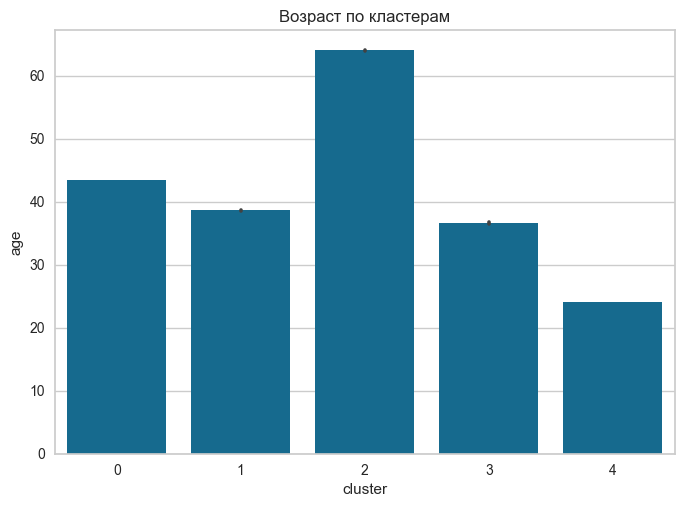

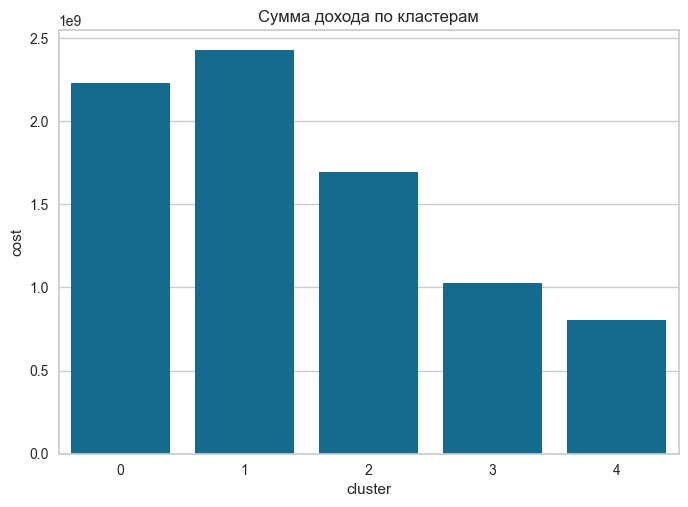

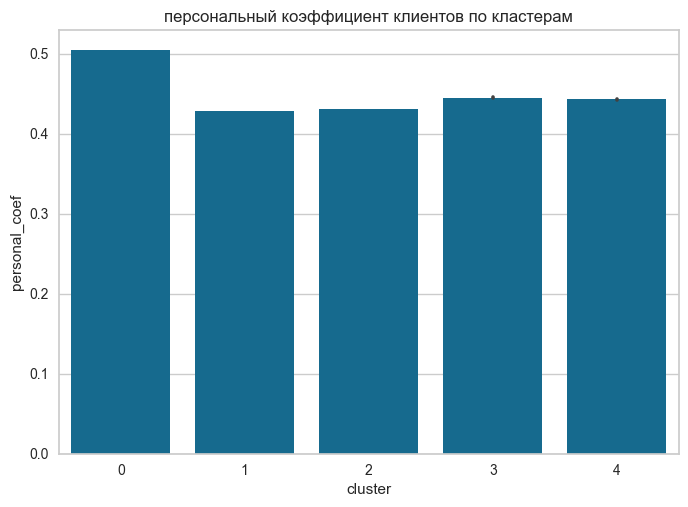

In [71]:
# Визуализация характеристик кластеров
sns.barplot(x='cluster', y='age', data=city_1188_clast)
plt.title('Возраст по кластерам')
plt.show()

# Группируем данные по 'cluster' и вычисляем сумму 'cost'
df_aggregated = city_1188_clast.groupby('cluster', as_index=False)['cost'].sum()

sns.barplot(x='cluster', y='cost', data=df_aggregated)
plt.title('Сумма дохода по кластерам')
plt.show()

sns.barplot(x='cluster', y='personal_coef', data=city_1188_clast)
plt.title('персональный коэффициент клиентов по кластерам')
plt.show()

### ОБЩИЕ ВЫВОДЫ